In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio

from pathlib import Path

import altair as alt
from altair.expr import datum

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

ipywidgets7.2.1
pandas    0.23.4
numpy     1.15.4
scipy     1.1.0
altair    2.1.0



## Set paths 

In [4]:
data_path = Path('../data')
path_to_results = data_path / "simulation_results"
khodayari_path = path_to_results / "Khodayari"
millard_path = path_to_results / "Millard"
kurata_path = path_to_results / "Kurata"
chassagnole_path = path_to_results / "Chassagnole"

In [5]:
# Load ID dataframes
khod_idf = pd.read_csv(data_path / "khodayari_id.csv")
millard_idf = pd.read_csv(data_path / "millard_id.csv")
kurata_idf = pd.read_csv(data_path / "kurata_id.csv")
chassagnole_idf = pd.read_csv(data_path / "chassagnole_id.csv")

In [6]:
from utils import (
    get_kurata_dilutions,    
    load_khodayari,
    load_kurata,
    load_millard,
    loadmat
)

In [7]:
# useful metrics to compare data
from utils import relative_error, normalized_error

# 1. Load the simulation data

In [8]:
kurata_dil = load_kurata(
    sample_names="all",
    load_path=kurata_path / "dilutions",
    id_df=kurata_idf,
    files=get_kurata_dilutions(),
)

Loaded data file for sample 0.2 which has flux matrix of (2101, 155)
Loaded data file for sample 0.4 which has flux matrix of (2101, 155)
Loaded data file for sample 0.6 which has flux matrix of (2101, 155)
Loaded data file for sample 0.7 which has flux matrix of (2101, 155)


# 2. Load experimental data and mix it with simulation data

In [9]:
yao_df = pd.read_csv(data_path / "datasets" / "yao2011_tidy.csv")
consumption_rates = yao_df.query('Measurement_Type == "consumption_rate"')
yao_fluxes = yao_df.query('Measurement_Type == "flux"')

In [10]:
# Ad-hoc function to divide every flux to corresponding consumption rate
def normalize_to_uptake(group):
    consumption_rate = consumption_rates.loc[consumption_rates.Dilution == group.name, 'Value'].values[0]
    print(f'Consumption rate for D {group.name} is {consumption_rate}')
    group = group.assign(normalized_flux = lambda x: x.Value / consumption_rate * 100)
    return(group)

In [11]:
yao_normalized = yao_fluxes.groupby('Dilution').apply(normalize_to_uptake).reset_index(drop = True)

Consumption rate for D 0.2 is 3.07
Consumption rate for D 0.2 is 3.07
Consumption rate for D 0.4 is 4.75
Consumption rate for D 0.6 is 6.67
Consumption rate for D 0.7 is 8.05


In [19]:
df = yao_normalized

df = df.assign(author="Yao")
df = df.rename(
    {
        "Measurement_ID": "BiGG_ID",        
        "Value": "flux",
        "Original_ID": "ID",
        "Dilution": "sample_id",
    },
    axis=1,
)
df = df[df["Measurement_Type"] == "flux"]

df = df[["flux", "ID", "BiGG_ID", "author", "sample_id", "normalized_flux"]]
df.sample_id = df.sample_id.apply(str)
exp_results = df

In [20]:
exp_results.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,3.07,GLCptspp,GLCptspp,Yao,0.2,100.000000
1,2.73,PGI,PGI,Yao,0.2,88.925081
2,2.81,PFK+FBA,PFK,Yao,0.2,91.530945
3,2.81,PFK+FBA,FBA,Yao,0.2,91.530945
4,5.60,GAPD+PGK,GAPD,Yao,0.2,182.410423


In [21]:
all_results = pd.concat([kurata_dil, exp_results], sort=False)

In [22]:
all_results.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,0.388458,vgrowth,NaN,Kurata,0.2,0.030134
1,1281.731177,vPts1,GLCptspp,Kurata,0.2,99.427420
2,1281.731177,vPts4,GLCptspp,Kurata,0.2,99.427420
3,4.414001,vPts4_medium,GLCptspp,Kurata,0.2,0.342406
4,7.381198,vNonpts,GLCtex,Kurata,0.2,0.572580


# 3. Subselect specific data and calculate error metrics

In [23]:
common_fluxes = set(exp_results["BiGG_ID"].unique()).intersection(
    set(kurata_idf["BiGG ID"].unique())
)

In [24]:
common_fluxes = {x for x in common_fluxes if pd.notna(x)}
#common_fluxes

In [25]:
selected_reactions = [x for x in common_fluxes if pd.notna(x)]

selected_strains = ["0.2", "0.4", "0.6", "0.7"]
selected_authors = ["Kurata", "Yao"]
experimental_dataset = "Yao"


selected_data = (
    all_results.query(
        """ BiGG_ID in @selected_reactions and sample_id in @selected_strains and author in @ selected_authors """
    )
    .groupby(["BiGG_ID", "sample_id", "author"])
    .median()
    .reset_index()
)

# Calculate relative error
selected_data = (
    selected_data.groupby(["BiGG_ID", "sample_id"])
    .apply(relative_error, exp_name=experimental_dataset)
    .reset_index()
    .drop("level_2", axis=1)
)
# Calculate summary errors
normalized_errors = (
    selected_data.groupby(["sample_id"])
    .apply(normalized_error, exp_name=experimental_dataset)
    .unstack()
    .reset_index()
    .rename({0: "normalized_error"}, axis=1)
)

In [26]:
normalized_errors

,author,sample_id,normalized_error
0,Kurata,0.2,0.529254
1,Kurata,0.4,0.376964
2,Kurata,0.6,0.309326
3,Kurata,0.7,0.321944
4,Yao,0.2,0.000000
5,Yao,0.4,0.000000
6,Yao,0.6,0.000000
7,Yao,0.7,0.000000


# 4. Visualize

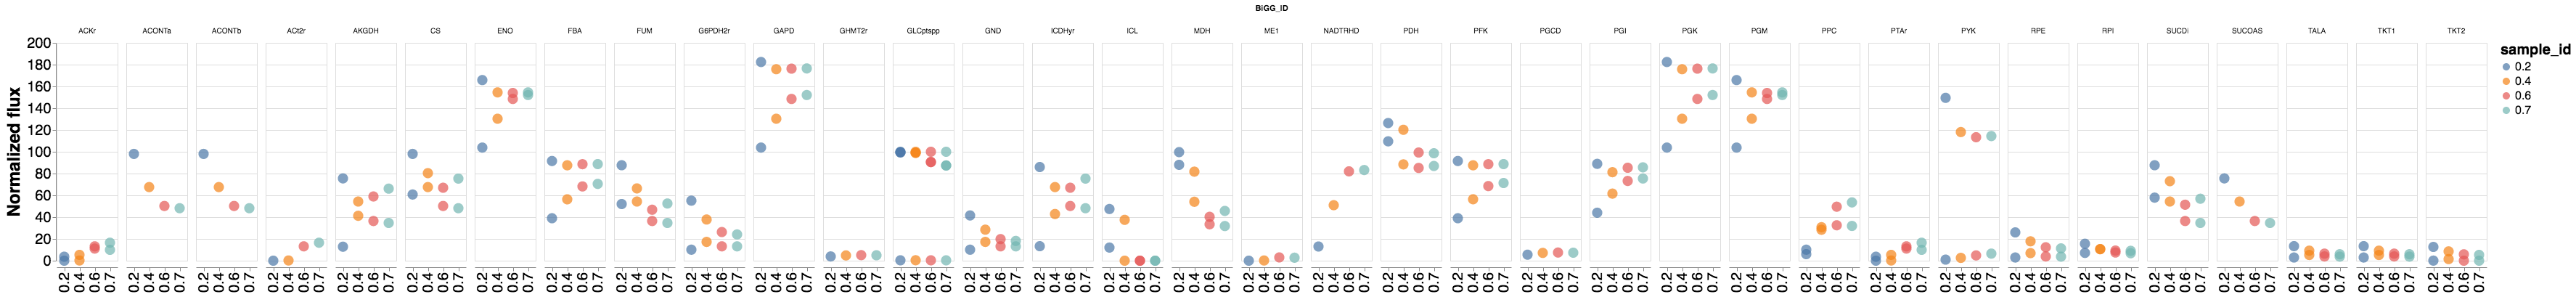

In [27]:
# put errors for each dataset as datapoints
chart = (
    alt.Chart(
        all_results.query('BiGG_ID in @exp_results.BiGG_ID.unique()'),
        # title = "Normalized error, ZWF sensitivity"
    )
    .mark_circle(size=200)
    .encode(
        y=alt.Y("normalized_flux", title="Normalized flux"),
        color=alt.Color("sample_id:N"),
        tooltip = ["author", "sample_id"],
        x=alt.X("sample_id:N", title=None),
    )
    .facet(column="BiGG_ID:N")
    .configure_axis(labelFontSize=20, titleFontSize=24)
    .configure_legend(labelFontSize=16, titleFontSize=20)
)

chart
# (errors + mean_error).properties(width=600, height = 500).configure_axis(labelFontSize = 20, titleFontSize = 24).configure_legend(labelFontSize = 16, titleFontSize = 20)
# errors

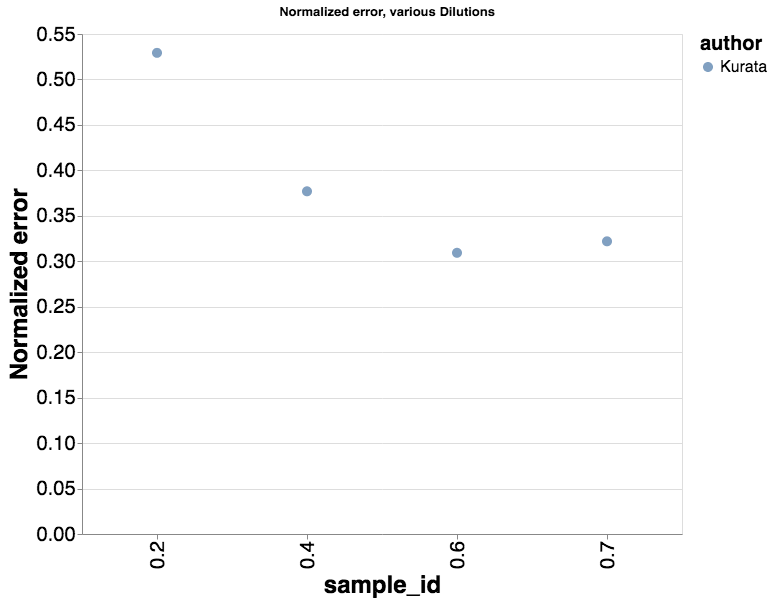

In [28]:
# put errors for each dataset as datapoints
errors = alt.Chart(
    normalized_errors.query("author != 'Yao'"),
    title = "Normalized error, various Dilutions"
).mark_circle(size = 100).encode(
    y=alt.Y("normalized_error", title = "Normalized error"),   
    color=alt.Color("author", sort=["Kurata"]),
    tooltip = ["author", "sample_id", "normalized_error"],
    x=alt.X("sample_id", sort=["0.2", "0.4", "0.6", "0.7"]),
)

errors.properties(width=600, height = 500).configure_axis(labelFontSize = 20, titleFontSize = 24).configure_legend(labelFontSize = 16, titleFontSize = 20)
# errors